In [31]:
from __future__ import division #always returns approximations from divisions
import numpy as np
import matplotlib.pyplot as plt
import ephem #for astronomy calculations, converting coordinate systems
import pandas as pd
from astroquery.gaia import Gaia

In [32]:
v_df = pd.read_csv('nh_ephemeris_3mon.txt', skiprows = 35, skipfooter=164-113, engine='python') # df of info about new horizon's position
s_df = pd.DataFrame(columns = ['source_id', 'g_abs', 'bp_rp', 'parallax', 'dist']) # df of info about stars

print(v_df)

                  date na1 na2         ra       dec  Unnamed: 5
0    2006-Jan-20 00:00          207.08781 -10.02864         NaN
1    2006-Apr-20 00:00          193.72256  -3.77013         NaN
2    2006-Jul-20 00:00          205.15145  -9.49166         NaN
3    2006-Oct-20 00:00          229.81708 -17.67692         NaN
4    2007-Jan-20 00:00          251.79649 -21.74582         NaN
..                 ...  ..  ..        ...       ...         ...
71   2023-Oct-20 00:00          288.01237 -20.41163         NaN
72   2024-Jan-20 00:00          289.32139 -20.28031         NaN
73   2024-Apr-20 00:00          290.20192 -20.12720         NaN
74   2024-Jul-20 00:00          289.07403 -20.24147         NaN
75   2024-Oct-20 00:00          288.32583 -20.37018         NaN

[76 rows x 6 columns]


In [33]:
for i in range(len(v_df.index)):
    #query to cone search around given new horizons's position
    query = """SELECT source_id, phot_g_mean_mag+5*log10(ABS(parallax)/1000)+5 AS g_abs, bp_rp, parallax, abs(1000/parallax) AS dist
    FROM gaiaedr3.gaia_source
    WHERE 1=CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', """ + str(v_df['ra'][i]) + """,""" + str(v_df['dec'][i]) + """, 0.035603))
    """
    
    results = Gaia.launch_job_async(query).get_results() #results from gaia query
    results = results.to_pandas().dropna() #convert to pandas

    s_df = pd.concat([s_df, results], ignore_index = True)
    
s_df = s_df.drop_duplicates(subset=['source_id']) #only keep unique rows
print(s_df)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [34]:
s_df.to_csv('nh_stars_3mon.csv') #save stars
s_df1 = s_df[s_df['dist'] <= 100]
s_df1.to_csv('nh_stars_within100.csv')
print(s_df1)

                 source_id      g_abs     bp_rp   parallax       dist
2778   4117066834369677056  16.526166  2.127939 -16.283780  61.410802
2801   4117066834499881216  15.114125  2.286634 -12.088056  82.726288
5403   4118001281784474880  15.705487  1.962931 -12.410045  80.579884
6812   4117232860703242240   0.999717  1.043702  10.199705  98.042048
6976   4117232998080843136  16.098714  1.867624  24.823043  40.285150
7008   4117232998142091392  15.579579  1.993935 -20.124874  49.689752
7901   4117236227900982272  16.818878  1.067900 -18.027410  55.471086
8278   4090772769705968640  15.569960  1.995985  11.047357  90.519386
19892  4079099387851409664  15.385267  3.895441  10.614394  94.211688
27061  4079643856592171008  15.804360  1.584820  19.948736  50.128489
32255  4082316116509482752   5.320351  0.979694  10.066591  99.338490
41655  4082192524522250368  15.349368  1.021776  11.382359  87.855252
45195  4082298936624094720  14.938539  1.098589 -11.418862  87.574403
52433  4082930223797

<ipython-input-35-236878de8521>:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("hot"))
  color_map.set_bad(color='white') #set color as white for masked values


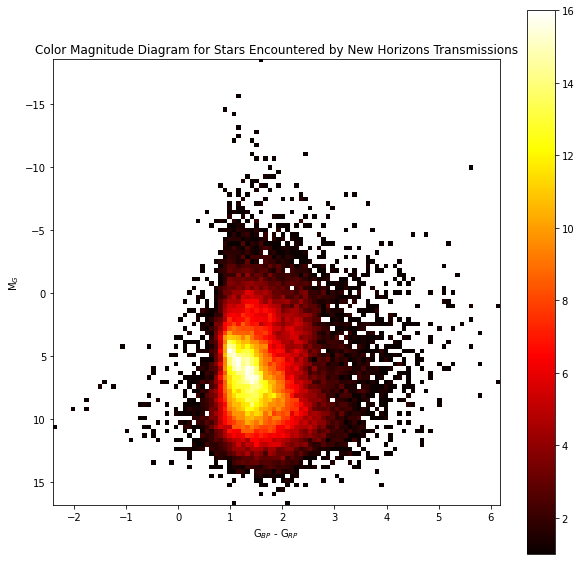

In [35]:
#build hr diagram
histogram, xedges, yedges = np.histogram2d(
   s_df['bp_rp'], s_df['g_abs'], bins=100)

histogram = np.ma.masked_where(histogram == 0.0, histogram) #map zero values
histogram = histogram.T #list bins with common y range

color_map = plt.cm.get_cmap("hot") #set colors for diagram
color_map.set_bad(color='white') #set color as white for masked values

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]] #bounding box in data

#plotting

plt.figure(figsize=(10, 10))

#plt.savefig('gaia_100_parsecs.png')
plt.imshow(np.sqrt(histogram), origin='lower', cmap=color_map,
    extent=extent, aspect=(extent[1]-extent[0])/(extent[3]-extent[2])
    )

plt.colorbar()
plt.title("Color Magnitude Diagram for Stars Encountered by New Horizons Transmissions")
plt.xlabel('G$_{BP}$ - G$_{RP}$')
plt.ylabel('M$_G$')
plt.gca().invert_yaxis()
plt.savefig('nh_stars_hr.png')

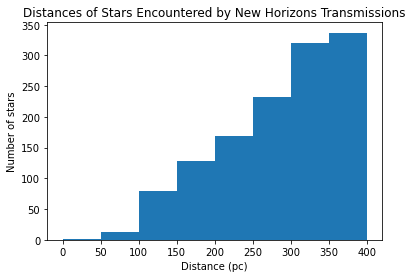

In [36]:
s_df = pd.read_csv('nh_stars_3mon.csv') #get csv

plt.hist(abs(1000/s_df['parallax']), bins = [0, 50, 100, 150, 200, 250, 300, 350, 400]) #plot parallax (mas) converted to distance (pc) in histogram

plt.title("Distances of Stars Encountered by New Horizons Transmissions") #labels
plt.xlabel("Distance (pc)")
plt.ylabel("Number of stars")

plt.savefig("nh_dist_hist_3mon.png")
plt.show()